# Spectral mixture kernel in 1d for GP

https://tinygp.readthedocs.io/en/latest/tutorials/kernels.html#example-spectral-mixture-kernel

In this section, we will implement the "spectral mixture kernel" proposed by [Gordon Wilson & Adams (2013)](https://arxiv.org/abs/1302.4245).

In [1]:
%%capture
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

try:
    import tinygp
except ModuleNotFoundError:
    %pip install -qq tinygp
    import tinygp

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

import seaborn as sns

In [2]:
pml.latexify(width_scale_factor=2)
plt.rcParams["legend.fontsize"] = 8 if pml.is_latexify_enabled() else "medium"
scattersize = 3 if pml.is_latexify_enabled() else 6

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
class SpectralMixture(tinygp.kernels.Kernel):
    def __init__(self, weight, scale, freq):
        self.weight = jnp.atleast_1d(weight)
        self.scale = jnp.atleast_1d(scale)
        self.freq = jnp.atleast_1d(freq)

    def evaluate(self, X1, X2):
        tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
        return jnp.sum(
            self.weight
            * jnp.prod(
                jnp.exp(-2 * jnp.pi**2 * tau**2 / self.scale**2) * jnp.cos(2 * jnp.pi * self.freq * tau),
                axis=-1,
            )
        )

Now let's implement the  simulate some data from this model:

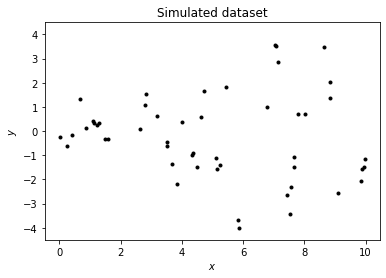

In [4]:
def build_gp(theta):
    kernel = SpectralMixture(
        jnp.exp(theta["log_weight"]),
        jnp.exp(theta["log_scale"]),
        jnp.exp(theta["log_freq"]),
    )
    return tinygp.GaussianProcess(kernel, train_input, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"])


params = {
    "log_weight": np.log([1.0, 1.0]),
    "log_scale": np.log([10.0, 20.0]),
    "log_freq": np.log([1.0, 1.0 / 3.0]),
    "log_diag": np.log(0.1),
    "mean": 0.0,
}

random = np.random.default_rng(546)
train_input = np.sort(random.uniform(0, 10, 50))
true_gp = build_gp(params)
train_output = true_gp.sample(jax.random.PRNGKey(123))

plt.figure()
plt.plot(train_input, train_output, ".k", markersize=scattersize)
plt.ylim(-4.5, 4.5)
plt.title("Simulated dataset")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

One thing to note here is that we've used named parameters in a dictionary, instead of an array of parameters as in some of the other examples.
This would be awkward (but not impossible) to fit using `scipy`, so instead we'll use [`optax`](https://github.com/deepmind/optax) for optimization:

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


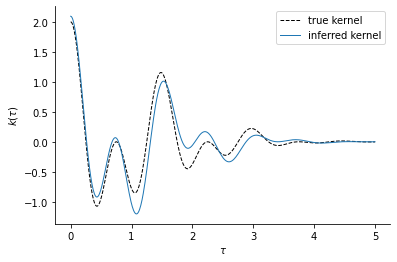

In [5]:
@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).log_probability(train_output)


opt = optax.sgd(learning_rate=3e-4)
opt_state = opt.init(params)
for i in range(1000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

opt_gp = build_gp(params)
tau = np.linspace(0, 5, 500)

plt.figure()
plt.plot(tau, true_gp.kernel(tau[:1], tau)[0], "--k", lw=1, label="true kernel")
plt.plot(tau, opt_gp.kernel(tau[:1], tau)[0], lw=1, label="inferred kernel")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$k(\tau)$")
plt.legend()
sns.despine()
pml.savefig("gp-spectral-mixture-learned-kernel")

Using our optimized model, over-plot the conditional predictions:

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


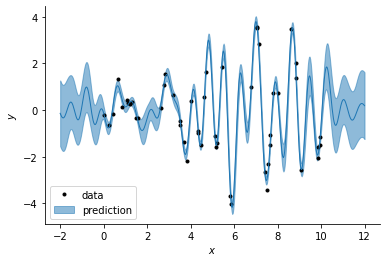

In [6]:
test_input = np.linspace(-2, 12, 500)
pred_gp = opt_gp.condition(train_output, test_input).gp
mu, variance = pred_gp.loc, pred_gp.variance

plt.figure()
plt.plot(train_input, train_output, ".k", label="data", markersize=scattersize)
plt.fill_between(
    test_input,
    mu + np.sqrt(variance),
    mu - np.sqrt(variance),
    color="C0",
    alpha=0.5,
    label="prediction",
)

plt.plot(test_input, mu, color="C0", lw=1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc="lower left")
sns.despine()
pml.savefig("gp-spectral-mixture-pred")